In [1]:
# We import the necessary libraries
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# We define a time domain
geom = dde.geometry.TimeDomain(0, 0.25)

In [3]:
# Our exact solution
def func(t):
    return 50 / 81 + t * 5 / 9 - 2 * np.exp(t) + (31 / 81) * np.exp(9 * t)

In [4]:
def gen_truedata():
    t = np.linspace(0., 0.25, 25)
    return t, func(t)

In [5]:
# Real value of parameters
a = -10
b = 9

In [6]:
# Our aim is to find the 2 unknown variables (A and B) for the system of equations.
A = dde.Variable(1.)
B = dde.Variable(1.)

In [7]:
# We express the residual of the ODE
def ode(t, y):
    dy_dt = dde.grad.jacobian(y, t)
    d2y_dt2 = dde.grad.hessian(y, t)
    return d2y_dt2 + A * dy_dt + B * y - 5 * t

In [8]:
# Define the initial condition y(0) = -1
ic1 = dde.icbc.IC(geom, lambda x: -1, lambda _, on_initial: on_initial)

In [9]:
# Now we want to define the initial condition y'(0) = 2
def boundary_l(t, on_boundary):
    return on_boundary and dde.utils.isclose(t[0], 0)

def error_2(inputs, outputs, X):
    return dde.grad.jacobian(outputs, inputs, i=0, j=None) - 2

ic2 = dde.icbc.OperatorBC(geom, error_2, boundary_l)

In [10]:
observe_t, ob_y = gen_truedata()
observe_t = observe_t.reshape(25, 1)
ob_y = ob_y.reshape(25,1)
observe_y = dde.icbc.PointSetBC(observe_t, ob_y[:, 0:1], component=0)

In [11]:
# We define the PDE problem
data = dde.data.TimePDE(geom, ode, [ic1, ic2, observe_y], num_domain=400,
    num_boundary=2, anchors=observe_t, num_test=500, solution=func)

In [12]:
# We define the network
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

In [13]:
external_trainable_variables = [A,B]

variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

Compiling model...
Building feed-forward neural network...
'build' took 0.018467 s

'compile' took 0.189615 s



/Users/giuliadesanctis/PycharmProjects/compStat/venv/lib/python3.11/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2024-03-10 23:03:39.684820: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.22e-01, 1.00e+00, 1.98e+00, 6.52e-01]    [1.20e-01, 1.00e+00, 1.98e+00, 6.52e-01]    [9.72e-01]    
1000      [1.85e-04, 9.57e-02, 6.22e-03, 5.74e-01]    [1.82e-04, 9.57e-02, 6.22e-03, 5.74e-01]    [8.92e-01]    
2000      [1.98e-04, 9.43e-02, 6.65e-03, 5.67e-01]    [1.94e-04, 9.43e-02, 6.65e-03, 5.67e-01]    [8.86e-01]    
3000      [2.09e-04, 9.09e-02, 6.72e-03, 5.56e-01]    [2.09e-04, 9.09e-02, 6.72e-03, 5.56e-01]    [8.78e-01]    
4000      [1.02e-04, 8.53e-02, 9.72e-03, 5.36e-01]    [1.01e-04, 8.53e-02, 9.72e-03, 5.36e-01]    [8.61e-01]    
5000      [1.79e-04, 7.91e-02, 7.54e-03, 5.13e-01]    [1.76e-04, 7.91e-02, 7.54e-03, 5.13e-01]    [8.42e-01]    
6000      [2.09e-04, 7.34e-02, 7.97e-03, 4.92e-01]    [2.07e-04, 7.34e-02, 7.97e-03, 4.92e-01]    [8.25e-01]    
7000      [5.82e-04, 6.92e-02, 7.59e-03, 4.75e-01]    [5.83e-04, 6.92e-02, 7.

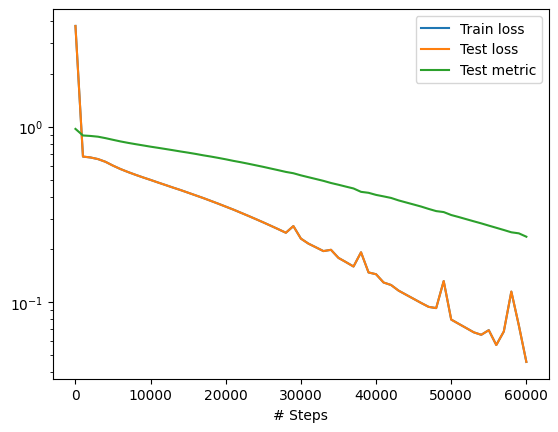

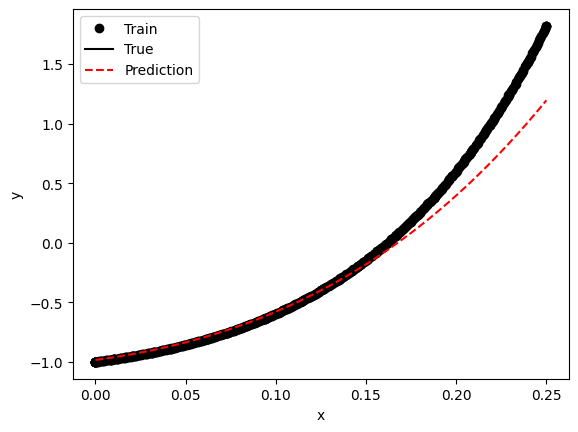

In [14]:
# Create the model
model = dde.Model(data, net)
model.compile("adam", lr=.001, external_trainable_variables=external_trainable_variables, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=60000, callbacks=[variable])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)